# Bio Bert Model


In [5]:
# Cell 1: Imports and Setup
import os, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import re

In [6]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [7]:
# Device setup
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")

Using device: mps


In [8]:
# Create necessary directories for saving models and results
import os
os.makedirs("model/batch_1", exist_ok=True)
os.makedirs("results", exist_ok=True)

## 1. Read in Data 

In [9]:
# Load data
df = pd.read_csv('../data/processed/shuffled_10_data.csv')
print(df.shape)
df.head()

(53130, 7)


,AC,PMID,Title,Abstract,Terms,Text_combined,batch_number
0,Q8NML3,17183211,"RamA, the transcriptional regulator of acetate...",The RamA protein represents a LuxR-type transc...,autoregulation,"RamA, the transcriptional regulator of acetate...",1
1,Q9SCZ4,17673660,The FERONIA receptor-like kinase mediates male...,"In flowering plants, signaling between the mal...",autophosphorylation,The FERONIA receptor-like kinase mediates male...,1
2,Q81WX1,12721629,The genome sequence of Bacillus anthracis Ames...,Bacillus anthracis is an endospore-forming bac...,NaN,The genome sequence of Bacillus anthracis Ames...,1
3,P14410,8521865,Phosphorylation of the N-terminal intracellula...,This paper reports the phosphorylation of the ...,NaN,Phosphorylation of the N-terminal intracellula...,1
4,P36898,14523231,Mutations in bone morphogenetic protein recept...,Brachydactyly (BD) type A2 is an autosomal dom...,autophosphorylation,Mutations in bone morphogenetic protein recept...,1


## 2. Clean Data

In [10]:
# Cell 3: Clean text
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Handle NaN values
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    # Keep hyphens as they may be important in biomedical terms
    text = re.sub(r'[^\w\s-]', '', text)
    # Keep numbers that might be part of important terms
    # text = re.sub(r'\d+', '', text)
    text = " ".join([word.strip() for word in text.split() if word not in stop_words])
    return text

df['Text_Cleaned'] = df['Text_combined'].apply(clean_text)

# Fill nan with 'non-autoregulatory'
df['Terms'] = df['Terms'].fillna('non-autoregulatory')

# Keep only selected columns
columns_to_keep = ['batch_number', 'Text_Cleaned', 'Terms']
df_cleaned = df[columns_to_keep]

In [11]:
print(df_cleaned.shape)
df_cleaned.head()

(53130, 3)


,batch_number,Text_Cleaned,Terms
0,1,rama transcriptional regulator acetate metabol...,autoregulation
1,1,feronia receptor-like kinase mediates male-fem...,autophosphorylation
2,1,genome sequence bacillus anthracis ames compar...,non-autoregulatory
3,1,phosphorylation n-terminal intracellular tail ...,non-autoregulatory
4,1,mutations bone morphogenetic protein receptor ...,autophosphorylation


## 3. Preprocess Data

In [12]:
# Cell 4: Prepare labels
# Convert terms to list
df_cleaned['Terms_List'] = df_cleaned['Terms'].apply(
    lambda x: [term.strip() for term in x.split(',')]
)
df_cleaned['Terms_List'] = df_cleaned['Terms_List'].apply(lambda x: list(set(x)))

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_cleaned['Terms_List'])
label_columns = mlb.classes_

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_6298/649158024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Terms_List'] = df_cleaned['Terms'].apply(
/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_6298/649158024.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Terms_List'] = df_cleaned['Terms_List'].apply(lambda x: list(set(x)))


In [13]:

labels_df = pd.DataFrame(labels, columns=label_columns)
existing_columns = [col for col in label_columns if col in df_cleaned.columns]
df_cleaned = df_cleaned.drop(columns=existing_columns, errors='ignore')
df_cleaned = pd.concat([df_cleaned, labels_df], axis=1)

In [14]:
print(df_cleaned.shape)
df_cleaned.head()

(53130, 19)


,batch_number,Text_Cleaned,Terms,Terms_List,autoactivation,autocatalysis,autocatalytic,autofeedback,autoinducer,autoinduction,autoinhibition,autoinhibitory,autokinase,autolysis,autophosphorylation,autoregulation,autoregulatory,autoubiquitination,non-autoregulatory
0,1,rama transcriptional regulator acetate metabol...,autoregulation,[autoregulation],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,feronia receptor-like kinase mediates male-fem...,autophosphorylation,[autophosphorylation],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,genome sequence bacillus anthracis ames compar...,non-autoregulatory,[non-autoregulatory],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,phosphorylation n-terminal intracellular tail ...,non-autoregulatory,[non-autoregulatory],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,mutations bone morphogenetic protein receptor ...,autophosphorylation,[autophosphorylation],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## 4. Train Model

In [15]:
# Step 6: Instantiate the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")


In [16]:
# Data Splitting
def split_single_batch_data(batch_number, test_size=0.2, random_state=42):
    """
    Split data from a single batch into train and test sets using stratified sampling.
    """
    batch_df = df_cleaned[df_cleaned['batch_number'] == batch_number].copy()
    
    if len(batch_df) == 0:
        print(f"Warning: No data found for batch {batch_number}")
        return None, None, None, None
        
    X = batch_df['Text_Cleaned']
    y = labels_df.loc[batch_df.index].values  # Ensure indexing alignment
    
    # Calculate label distribution
    non_auto_count = len(batch_df[batch_df['Terms'] == 'non-autoregulatory'])
    auto_count = len(batch_df[batch_df['Terms'] != 'non-autoregulatory'])
    
    try:
        # Split data
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        
        for train_idx, test_idx in msss.split(X, y):
            X_train = X.iloc[train_idx]
            X_test = X.iloc[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
        
        print(f"Batch {batch_number} | Train: {len(X_train)}, Test: {len(X_test)} | Non-auto: {non_auto_count}, Auto: {auto_count}")
        
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Error in splitting batch {batch_number}: {e}")
        # Fallback to regular train_test_split if stratified splitting fails
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Fallback split for batch {batch_number} | Train: {len(X_train)}, Test: {len(X_test)}")
        return X_train, X_test, y_train, y_test

In [17]:
# Calculate class weights
def get_data_and_weights(batch_number):
    """
    Get data and calculate class weights for a specific batch.
    """
    X_train, X_test, y_train, y_test = split_single_batch_data(batch_number)
    
    if X_train is None:
        return None, None, None, None, None
    
    # Calculate class weights
    pos_weights = []
    for i in range(y_train.shape[1]):
        neg_count = len(y_train) - np.sum(y_train[:, i])
        pos_count = np.sum(y_train[:, i])
        # Handle the case where a class might have no positive examples
        if pos_count == 0:
            pos_weights.append(1.0)  # Default weight
        else:
            # Calculate weight and clip to prevent extreme values
            weight = neg_count / pos_count
            weight = min(max(weight, 0.1), 10.0)  # Clip between 0.1 and 10
            pos_weights.append(weight)
    
    pos_weights = torch.FloatTensor(pos_weights).to(device)
    
    return X_train, X_test, y_train, y_test, pos_weights

In [18]:
# Cell 6: Dataset and DataLoader classes
# Create dataset class
class BioBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }


In [19]:
# Create data loader
def create_dataset_and_loader(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = BioBERTDataset(X_train, y_train, tokenizer)
    test_dataset = BioBERTDataset(X_test, y_test, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader

In [20]:
# Cell 7: Model Architecture
# Improved BioBERT Classifier with intermediate layers
class ImprovedBioBERTClassifier(nn.Module):
    def __init__(self, n_classes, dropout1=0.1, dropout2=0.2):
        super(ImprovedBioBERTClassifier, self).__init__()
        # Create a fresh copy of the model
        self.bert = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
        
        # Add an intermediate layer
        self.dropout1 = nn.Dropout(dropout1)
        self.intermediate = nn.Linear(self.bert.config.hidden_size, 512)
        self.activation = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.classifier = nn.Linear(512, n_classes)
        
        # Initialize weights
        nn.init.xavier_normal_(self.intermediate.weight)
        nn.init.zeros_(self.intermediate.bias)
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        pooled_output = self.dropout1(pooled_output)
        intermediate = self.intermediate(pooled_output)
        intermediate = self.activation(intermediate)
        intermediate = self.dropout2(intermediate)
        logits = self.classifier(intermediate)
        return logits


In [21]:
# Cell 8: Training and Evaluation Functions
# Training function with improvements
def train_epoch(model, data_loader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0
    total_batches = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Check for NaN loss
            if torch.isnan(loss):
                print("WARNING: NaN loss detected, skipping batch")
                continue
                
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            total_loss += loss.item()
            total_batches += 1
        except Exception as e:
            print(f"Error in batch processing: {e}")
            continue
    
    # Protect against division by zero
    if total_batches == 0:
        return float('inf')
    
    return total_loss / total_batches

# Optimize thresholds for each label
def optimize_thresholds(model, val_loader, n_labels):
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Optimizing thresholds"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            outputs = model(input_ids, attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            
            all_outputs.append(probs)
            all_labels.append(labels.numpy())
    
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    
    optimal_thresholds = []
    
    for i in range(n_labels):
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in np.arange(0.3, 0.7, 0.05):
            preds = (all_outputs[:, i] >= threshold).astype(int)
            f1 = f1_score(all_labels[:, i], preds, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        optimal_thresholds.append(best_threshold)
        
    return optimal_thresholds

# Evaluation function
def evaluate(model, data_loader, criterion, thresholds):
    """
    Evaluate the model with focused metrics output.
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            
            # Apply thresholds per label
            predictions = np.array([
                (probabilities[:, i] >= thresholds[i]).astype(int) for i in range(len(thresholds))
            ]).T

            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Samples metrics
    samples_precision = precision_score(all_labels, all_predictions, average='samples', zero_division=0)
    samples_recall = recall_score(all_labels, all_predictions, average='samples', zero_division=0)
    samples_f1 = f1_score(all_labels, all_predictions, average='samples', zero_division=0)

    # F1 metrics
    micro_f1 = f1_score(all_labels, all_predictions, average='micro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    weighted_f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    # Average loss
    avg_loss = total_loss / len(data_loader)

    metrics = {
        'loss': avg_loss,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'samples_f1': samples_f1,
        'samples_precision': samples_precision,
        'samples_recall': samples_recall
    }
    
    # Output results
    print(f"Loss: {avg_loss:.4f} | Micro F1: {micro_f1:.4f} | Macro F1: {macro_f1:.4f} | Weighted F1: {weighted_f1:.4f} | Samples F1: {samples_f1:.4f}")
    print(f"Samples Precision: {samples_precision:.4f} | Samples Recall: {samples_recall:.4f}")
    
    # Return metrics for further analysis
    return metrics


In [22]:
# Add this near the top of your code to create necessary directories
os.makedirs("model", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [23]:
# Cell 9: Main Training Function
def train_model(batch_number, n_epochs, learning_rate, batch_size, use_optimal_thresholds=True):
    """
    Training loop for a single batch with dynamic threshold settings.
    """
    # Get data
    data_result = get_data_and_weights(batch_number)
    
    if data_result[0] is None:
        print(f"Skipping batch {batch_number} due to data issues.")
        return
        
    X_train, X_test, y_train, y_test, pos_weights = data_result
    print(f"\nProcessing Batch {batch_number} ...")
    
    # Set initial thresholds
    initial_thresholds = [0.5] * y_train.shape[1]
    print(f"\nInitial Thresholds: {[f'{t:.2f}' for t in initial_thresholds]}")
    
    # Create data loaders
    train_loader, test_loader = create_dataset_and_loader(X_train, y_train, X_test, y_test, batch_size)
    
    # Initialize model
    model = ImprovedBioBERTClassifier(n_classes=y_train.shape[1]).to(device)
    
    # Set up loss and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Set up scheduler with warmup
    total_steps = len(train_loader) * n_epochs
    warmup_steps = int(total_steps * 0.1)  # 10% warmup
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Training loop
    best_samples_f1 = 0.0
    
    # Dictionary to track all metrics
    all_metrics = {
        'train_loss': [],
        'val_loss': [],
        'micro_f1': [],
        'macro_f1': [],
        'weighted_f1': [],
        'samples_f1': [],
        'samples_precision': [],
        'samples_recall': []
    }
    
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs} | Batch {batch_number}")
        
        # Train
        epoch_loss = train_epoch(model, train_loader, optimizer, criterion, scheduler)
        print(f"Training Loss: {epoch_loss:.4f}")
        all_metrics['train_loss'].append(epoch_loss)
        
        # Optimize thresholds if requested (only after first epoch)
        thresholds = initial_thresholds
        if use_optimal_thresholds and epoch >= 1:
            try:
                print("Optimizing thresholds...")
                thresholds = optimize_thresholds(model, test_loader, len(initial_thresholds))
                print(f"Optimized Thresholds: {[f'{t:.2f}' for t in thresholds]}")
            except Exception as e:
                print(f"Error optimizing thresholds: {e}")
                print("Using default thresholds")
                thresholds = initial_thresholds
        
        # Evaluate
        metrics = evaluate(model, test_loader, criterion, thresholds)
        
        # Store metrics
        for k, v in metrics.items():
            if k in all_metrics:
                all_metrics[k].append(v)
        
        current_samples_f1 = metrics['samples_f1']
        
        # Save best model and thresholds
        if current_samples_f1 > best_samples_f1:
            best_samples_f1 = current_samples_f1
            
            # Create model directory if it doesn't exist
            model_dir = f"model/batch_{batch_number}"
            os.makedirs(model_dir, exist_ok=True)
            
            # Save model
            model_path = f"{model_dir}/best_model.pt"
            torch.save(model.state_dict(), model_path)
            print(f"  New best model saved to {model_path}")
            
            # Save thresholds
            thresholds_path = f"{model_dir}/best_thresholds.json"
            with open(thresholds_path, "w") as f:
                json.dump(thresholds, f)
            print(f"  Thresholds saved to {thresholds_path}")
    
    # Save metrics history
    metrics_path = f"results/metrics_batch_{batch_number}.json"
    with open(metrics_path, "w") as f:
        json.dump(all_metrics, f)
    print(f"Metrics saved to {metrics_path}")
    
    # Save label columns
    with open('label_columns.json', 'w') as f:
        json.dump(list(label_columns), f)
    
    return model, best_samples_f1


In [24]:
# Cell 10: Inference Class
class BioBERTInference:
    def __init__(self, model_path, thresholds_path, label_columns_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load label columns
        with open(label_columns_path, 'r') as f:
            self.label_columns = json.load(f)
        
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
        
        # Initialize model
        self.model = ImprovedBioBERTClassifier(n_classes=len(self.label_columns))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        
        # Load thresholds
        with open(thresholds_path, 'r') as f:
            self.thresholds = json.load(f)
    
    def preprocess(self, text):
        return clean_text(text)
    
    def predict(self, text):
        processed_text = self.preprocess(text)
        
        encoding = self.tokenizer(
            processed_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask)
            probabilities = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Apply thresholds and get predicted labels
        predictions = {}
        for i, label in enumerate(self.label_columns):
            if probabilities[i] >= self.thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        return predictions


In [25]:
# Cell 11: Run Training
# Change these parameters as needed
n_epochs = 7
learning_rate = 5e-6
batch_size = 8

# To train a specific batch
batch_num = 1  # Change this to the batch you want to train
model, f1_score = train_model(
    batch_number=batch_num,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    use_optimal_thresholds=True
)
print(f"Batch {batch_num} training complete. Best F1 score: {f1_score:.4f}")

Batch 1 | Train: 4248, Test: 1065 | Non-auto: 3542, Auto: 1771

Processing Batch 1 ...

Initial Thresholds: ['0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50', '0.50']
Epoch 1/7 | Batch 1


Training: 100%|██████████| 531/531 [16:02<00:00,  1.81s/it, loss=0.2179]


Training Loss: 0.4877


Evaluating: 100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


Loss: 0.2737 | Micro F1: 0.7476 | Macro F1: 0.2364 | Weighted F1: 0.7354 | Samples F1: 0.7659
Samples Precision: 0.7523 | Samples Recall: 0.7972
  New best model saved to model/batch_1/best_model.pt
  Thresholds saved to model/batch_1/best_thresholds.json
Epoch 2/7 | Batch 1


Training: 100%|██████████| 531/531 [17:17<00:00,  1.95s/it, loss=0.1089]


Training Loss: 0.1809
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 134/134 [01:25<00:00,  1.56it/s]


Optimized Thresholds: ['0.35', '0.50', '0.50', '0.30', '0.50', '0.50', '0.65', '0.45', '0.50', '0.65', '0.65', '0.65', '0.65', '0.65', '0.35']


Evaluating: 100%|██████████| 134/134 [01:26<00:00,  1.54it/s]


Loss: 0.0974 | Micro F1: 0.9067 | Macro F1: 0.6415 | Weighted F1: 0.9112 | Samples F1: 0.9169
Samples Precision: 0.9036 | Samples Recall: 0.9441
  New best model saved to model/batch_1/best_model.pt
  Thresholds saved to model/batch_1/best_thresholds.json
Epoch 3/7 | Batch 1


Training: 100%|██████████| 531/531 [17:31<00:00,  1.98s/it, loss=0.0249]


Training Loss: 0.1021
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 134/134 [01:31<00:00,  1.47it/s]


Optimized Thresholds: ['0.30', '0.50', '0.45', '0.30', '0.30', '0.35', '0.65', '0.65', '0.50', '0.55', '0.50', '0.65', '0.65', '0.65', '0.60']


Evaluating: 100%|██████████| 134/134 [01:31<00:00,  1.47it/s]


Loss: 0.0835 | Micro F1: 0.9369 | Macro F1: 0.7883 | Weighted F1: 0.9362 | Samples F1: 0.9363
Samples Precision: 0.9338 | Samples Recall: 0.9423
  New best model saved to model/batch_1/best_model.pt
  Thresholds saved to model/batch_1/best_thresholds.json
Epoch 4/7 | Batch 1


Training: 100%|██████████| 531/531 [17:07<00:00,  1.93s/it, loss=0.1045]


Training Loss: 0.0797
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 134/134 [01:23<00:00,  1.60it/s]


Optimized Thresholds: ['0.30', '0.50', '0.45', '0.30', '0.30', '0.30', '0.65', '0.35', '0.30', '0.50', '0.65', '0.50', '0.35', '0.45', '0.55']


Evaluating: 100%|██████████| 134/134 [01:24<00:00,  1.59it/s]


Loss: 0.0752 | Micro F1: 0.9382 | Macro F1: 0.8407 | Weighted F1: 0.9382 | Samples F1: 0.9391
Samples Precision: 0.9383 | Samples Recall: 0.9432
  New best model saved to model/batch_1/best_model.pt
  Thresholds saved to model/batch_1/best_thresholds.json
Epoch 5/7 | Batch 1


Training: 100%|██████████| 531/531 [17:25<00:00,  1.97s/it, loss=0.2058]


Training Loss: 0.0700
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 134/134 [01:24<00:00,  1.59it/s]


Optimized Thresholds: ['0.30', '0.50', '0.60', '0.30', '0.30', '0.30', '0.50', '0.40', '0.30', '0.45', '0.30', '0.30', '0.30', '0.60', '0.30']


Evaluating: 100%|██████████| 134/134 [01:37<00:00,  1.37it/s]


Loss: 0.0816 | Micro F1: 0.9456 | Macro F1: 0.8682 | Weighted F1: 0.9444 | Samples F1: 0.9484
Samples Precision: 0.9441 | Samples Recall: 0.9582
  New best model saved to model/batch_1/best_model.pt
  Thresholds saved to model/batch_1/best_thresholds.json
Epoch 6/7 | Batch 1


Training: 100%|██████████| 531/531 [17:18<00:00,  1.96s/it, loss=0.4400]


Training Loss: 0.0576
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 134/134 [01:24<00:00,  1.59it/s]


Optimized Thresholds: ['0.30', '0.50', '0.35', '0.30', '0.30', '0.30', '0.45', '0.35', '0.30', '0.65', '0.65', '0.35', '0.30', '0.30', '0.40']


Evaluating: 100%|██████████| 134/134 [01:29<00:00,  1.49it/s]


Loss: 0.0752 | Micro F1: 0.9435 | Macro F1: 0.8668 | Weighted F1: 0.9434 | Samples F1: 0.9460
Samples Precision: 0.9440 | Samples Recall: 0.9516
Epoch 7/7 | Batch 1


Training: 100%|██████████| 531/531 [16:40<00:00,  1.88s/it, loss=0.0121]


Training Loss: 0.0552
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 134/134 [01:23<00:00,  1.60it/s]


Optimized Thresholds: ['0.30', '0.50', '0.60', '0.30', '0.30', '0.30', '0.40', '0.40', '0.30', '0.45', '0.30', '0.35', '0.30', '0.30', '0.30']


Evaluating: 100%|██████████| 134/134 [01:26<00:00,  1.55it/s]

Loss: 0.0740 | Micro F1: 0.9438 | Macro F1: 0.8707 | Weighted F1: 0.9437 | Samples F1: 0.9474
Samples Precision: 0.9437 | Samples Recall: 0.9563
Metrics saved to results/metrics_batch_1.json
Batch 1 training complete. Best F1 score: 0.9484


In [26]:
import torch
import json
import numpy as np
from transformers import AutoTokenizer
import torch.nn as nn

# First, let's define a function to load the model and make predictions
def load_model_and_predict(text_samples):
    """
    Load the saved model and make predictions on text samples
    """
    # Load label columns
    try:
        with open('label_columns.json', 'r') as f:
            label_columns = json.load(f)
    except FileNotFoundError:
        # Fallback if file not found
        label_columns = [
            'autoactivation', 'autocatalysis', 'autocatalytic', 'autofeedback',
            'autoinducer', 'autoinduction', 'autoinhibition', 'autoinhibitory',
            'autokinase', 'autolysis', 'autophosphorylation', 'autoregulation',
            'autoregulatory', 'autoubiquitination', 'non-autoregulatory'
        ]
    
    # Define the model architecture (same as in training)
    class ImprovedBioBERTClassifier(nn.Module):
        def __init__(self, n_classes, dropout1=0.1, dropout2=0.2):
            super(ImprovedBioBERTClassifier, self).__init__()
            self.bert = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
            self.dropout1 = nn.Dropout(dropout1)
            self.intermediate = nn.Linear(self.bert.config.hidden_size, 512)
            self.activation = nn.ReLU()
            self.dropout2 = nn.Dropout(dropout2)
            self.classifier = nn.Linear(512, n_classes)
        
        def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            pooled_output = self.dropout1(pooled_output)
            intermediate = self.intermediate(pooled_output)
            intermediate = self.activation(intermediate)
            intermediate = self.dropout2(intermediate)
            logits = self.classifier(intermediate)
            return logits
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    
    # Initialize model
    model = ImprovedBioBERTClassifier(n_classes=len(label_columns)).to(device)
    
    # Load model weights
    try:
        model.load_state_dict(torch.load("model/batch_1/best_model.pt", map_location=device))
        print("Model loaded successfully!")
    except FileNotFoundError:
        print("Error: Model file not found. Make sure you have saved the model properly.")
        return None
    
    # Load thresholds
    try:
        with open("model/batch_1/best_thresholds.json", 'r') as f:
            thresholds = json.load(f)
        print("Thresholds loaded successfully!")
    except FileNotFoundError:
        print("Warning: Thresholds file not found. Using default threshold of 0.5.")
        thresholds = [0.5] * len(label_columns)
    
    # Set model to evaluation mode
    model.eval()
    
    # Preprocess and predict for each text
    results = []
    
    for text in text_samples:
        # Tokenize
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Move to device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            probabilities = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Get predictions above threshold
        predictions = {}
        for i, label in enumerate(label_columns):
            if probabilities[i] >= thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        # Get top 3 probabilities regardless of threshold
        top_indices = np.argsort(probabilities)[::-1][:3]
        top_3 = {label_columns[i]: float(probabilities[i]) for i in top_indices}
        
        # Append results
        results.append({
            'text': text,
            'predictions': predictions,
            'top_3': top_3,
            'all_probs': {label_columns[i]: float(probabilities[i]) for i in range(len(label_columns))}
        })
    
    return results

# Now, let's create diverse test cases

# Category 1: Obvious examples with "auto" terms in them
obvious_examples = [
    "The receptor undergoes autophosphorylation upon ligand binding, which triggers a signaling cascade.",
    "Transcription factors exhibiting autoregulation can bind to their own promoters to control expression levels.",
    "The protein kinase shows autoactivation through conformational changes in its catalytic domain.",
    "Bacterial quorum sensing relies on autoinducers that accumulate in the environment.",
    "Apoptosis involves proteases that undergo autocatalytic activation through proteolytic cleavage."
]

# Category 2: Less obvious examples (no "auto" terms)
less_obvious_examples = [
    "The transcription factor binds to its own promoter region, creating a negative feedback loop.",
    "Upon phosphorylation, the enzyme can activate additional copies of itself, creating a positive feedback circuit.",
    "The receptor dimerizes and cross-phosphorylates residues in the intracellular domain.",
    "The repressor protein inhibits its own gene expression when concentrations exceed a threshold.",
    "Bacterial cells produce signaling molecules that, when detected, stimulate further production of the same molecule."
]

# Category 3: Challenging cases with ambiguous regulatory mechanisms
challenging_examples = [
    "The protein shows increased activity following binding to its interaction partner, which itself is regulated by the same signaling pathway.",
    "Enzyme activity decreases following substrate binding, potentially through an allosteric mechanism involving the active site.",
    "Regulatory T cells suppress immune responses through multiple feedback mechanisms involving cytokine signaling.",
    "The gene locus contains binding sites for both activating and repressing factors that are co-expressed with the gene itself.",
    "Proteolytic processing of the prohormone yields bioactive peptides that modulate receptor sensitivity."
]

# Category 4: Negative cases (non-autoregulatory)
negative_examples = [
    "The housekeeping gene is constitutively expressed under normal cellular conditions.",
    "Protein translation is initiated at the ribosome following mRNA binding.",
    "Cell division requires the coordinated action of multiple cytoskeletal proteins.",
    "Passive diffusion of ions occurs through the membrane channel following a concentration gradient.",
    "The monoclonal antibody binds specifically to the epitope on the target antigen."
]

# Run prediction on all test sets
print("Testing model on obvious examples...")
obvious_results = load_model_and_predict(obvious_examples)

print("\nTesting model on less obvious examples...")
less_obvious_results = load_model_and_predict(less_obvious_examples)

print("\nTesting model on challenging examples...")
challenging_results = load_model_and_predict(challenging_examples)

print("\nTesting model on negative examples...")
negative_results = load_model_and_predict(negative_examples)

# Display results in a clear format
def display_test_results(results, category_name):
    print(f"\n=== {category_name} ===\n")
    
    for i, result in enumerate(results):
        print(f"Example {i+1}: \"{result['text']}\"")
        
        if result['predictions']:
            print("  Predicted classes (above threshold):")
            for label, prob in sorted(result['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"    - {label}: {prob:.4f}")
        else:
            print("  No classes above threshold")
        
        print("  Top 3 probabilities:")
        for label, prob in sorted(result['top_3'].items(), key=lambda x: x[1], reverse=True):
            print(f"    - {label}: {prob:.4f}")
        
        print()

# Display all results
if obvious_results:
    display_test_results(obvious_results, "Obvious Examples")
    
if less_obvious_results:
    display_test_results(less_obvious_results, "Less Obvious Examples")
    
if challenging_results:
    display_test_results(challenging_results, "Challenging Examples")
    
if negative_results:
    display_test_results(negative_results, "Negative Examples")

# Analyze overall performance
def analyze_performance(results_sets):
    categories = ["Obvious", "Less Obvious", "Challenging", "Negative"]
    
    print("\n=== Performance Analysis ===\n")
    
    for category, results in zip(categories, results_sets):
        if not results:
            continue
            
        # Count how many examples had at least one prediction
        predictions_count = sum(1 for r in results if r['predictions'])
        
        # Calculate average number of predicted classes
        avg_predictions = sum(len(r['predictions']) for r in results) / len(results)
        
        # Calculate confidence (average probability of top prediction)
        avg_confidence = sum(list(r['top_3'].values())[0] for r in results) / len(results)
        
        print(f"{category} Examples:")
        print(f"  Detection rate: {predictions_count}/{len(results)} ({predictions_count/len(results)*100:.1f}%)")
        print(f"  Average predicted classes: {avg_predictions:.2f}")
        print(f"  Average confidence: {avg_confidence:.4f}")
        
        # For non-negative categories, check if autoregulatory classes are detected
        if category != "Negative":
            auto_detected = sum(1 for r in results if any('auto' in label.lower() for label in r['predictions']))
            print(f"  Auto-related classes detected: {auto_detected}/{len(results)} ({auto_detected/len(results)*100:.1f}%)")
        # For negative category, check for false positives
        else:
            auto_detected = sum(1 for r in results if any('auto' in label.lower() and label != 'non-autoregulatory' for label in r['predictions']))
            print(f"  False positives (auto-related): {auto_detected}/{len(results)} ({auto_detected/len(results)*100:.1f}%)")
        
        print()

# Run performance analysis
if all([obvious_results, less_obvious_results, challenging_results, negative_results]):
    analyze_performance([obvious_results, less_obvious_results, challenging_results, negative_results])

Testing model on obvious examples...


/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_6298/1895935901.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/batch

Model loaded successfully!
Thresholds loaded successfully!

Testing model on less obvious examples...
Model loaded successfully!
Thresholds loaded successfully!

Testing model on challenging examples...
Model loaded successfully!
Thresholds loaded successfully!

Testing model on negative examples...
Model loaded successfully!
Thresholds loaded successfully!

=== Obvious Examples ===

Example 1: "The receptor undergoes autophosphorylation upon ligand binding, which triggers a signaling cascade."
  Predicted classes (above threshold):
    - autophosphorylation: 0.7972
    - autoregulation: 0.3231
  Top 3 probabilities:
    - autophosphorylation: 0.7972
    - autoregulation: 0.3231
    - autoinhibitory: 0.2873

Example 2: "Transcription factors exhibiting autoregulation can bind to their own promoters to control expression levels."
  Predicted classes (above threshold):
    - autoregulation: 0.8560
    - autoregulatory: 0.3619
  Top 3 probabilities:
    - autoregulation: 0.8560
    - auto

In [27]:
# Cell 7: Model Architecture
class EnhancedBioBERTClassifier(nn.Module):
    def __init__(self, n_classes, dropout1=0.1, dropout2=0.2):
        super(EnhancedBioBERTClassifier, self).__init__()
        # Load base BioBERT
        self.bert = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
        
        # Add relation attention mechanism
        self.relation_query = nn.Parameter(torch.randn(768, 1))
        self.relation_key = nn.Linear(768, 768)
        self.relation_value = nn.Linear(768, 768)
        
        # Main classification path
        self.dropout1 = nn.Dropout(dropout1)
        self.intermediate = nn.Linear(768 * 2, 512)  # Doubled for concatenation
        self.activation = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.classifier = nn.Linear(512, n_classes)
        
        # Initialize weights properly
        nn.init.xavier_normal_(self.intermediate.weight)
        nn.init.zeros_(self.intermediate.bias)
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, input_ids, attention_mask):
        # Get BioBERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get sequence outputs
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        cls_token = sequence_output[:, 0, :]  # [batch_size, hidden_size]
        
        # Apply relation attention
        attention_mask_expanded = attention_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        
        # Calculate relation-aware attention weights
        relation_keys = self.relation_key(sequence_output)  # [batch_size, seq_len, hidden_size]
        query = self.relation_query.unsqueeze(0).expand(input_ids.size(0), -1, -1)  # [batch_size, hidden_size, 1]
        
        # Get attention scores and mask padding tokens
        attention_scores = torch.bmm(relation_keys, query)  # [batch_size, seq_len, 1]
        attention_scores = attention_scores.masked_fill(attention_mask_expanded == 0, -10000.0)
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, seq_len, 1]
        
        # Get relation-aware context vector
        relation_values = self.relation_value(sequence_output)  # [batch_size, seq_len, hidden_size]
        relation_context = torch.sum(attention_weights * relation_values, dim=1)  # [batch_size, hidden_size]
        
        # Combine CLS token with relation context
        pooled_output = torch.cat([cls_token, relation_context], dim=1)  # [batch_size, hidden_size*2]
        pooled_output = self.dropout1(pooled_output)
        
        # Classification
        intermediate = self.intermediate(pooled_output)
        intermediate = self.activation(intermediate)
        intermediate = self.dropout2(intermediate)
        logits = self.classifier(intermediate)
        
        return logits, attention_weights

In [28]:
def convert_to_enhanced_model(original_model_path):
    """
    Load the existing model and convert it to the enhanced model
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load label columns
    try:
        with open('label_columns.json', 'r') as f:
            label_columns = json.load(f)
    except FileNotFoundError:
        # Fallback if file not found
        label_columns = [
            'autoactivation', 'autocatalysis', 'autocatalytic', 'autofeedback',
            'autoinducer', 'autoinduction', 'autoinhibition', 'autoinhibitory',
            'autokinase', 'autolysis', 'autophosphorylation', 'autoregulation',
            'autoregulatory', 'autoubiquitination', 'non-autoregulatory'
        ]
    
    # Define the original model architecture
    class ImprovedBioBERTClassifier(nn.Module):
        def __init__(self, n_classes, dropout1=0.1, dropout2=0.2):
            super(ImprovedBioBERTClassifier, self).__init__()
            self.bert = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
            self.dropout1 = nn.Dropout(dropout1)
            self.intermediate = nn.Linear(self.bert.config.hidden_size, 512)
            self.activation = nn.ReLU()
            self.dropout2 = nn.Dropout(dropout2)
            self.classifier = nn.Linear(512, n_classes)
        
        def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            pooled_output = self.dropout1(pooled_output)
            intermediate = self.intermediate(pooled_output)
            intermediate = self.activation(intermediate)
            intermediate = self.dropout2(intermediate)
            logits = self.classifier(intermediate)
            return logits
    
    # Load original model
    original_model = ImprovedBioBERTClassifier(n_classes=len(label_columns)).to(device)
    original_model.load_state_dict(torch.load(original_model_path, map_location=device))
    print("Original model loaded successfully!")
    
    # Create enhanced model
    enhanced_model = EnhancedBioBERTClassifier(n_classes=len(label_columns)).to(device)
    
    # Transfer weights from original model to enhanced model
    # 1. BERT weights
    enhanced_model.bert.load_state_dict(original_model.bert.state_dict())
    
    print("Enhanced model created and initialized with original BERT weights!")
    return enhanced_model, device, label_columns

In [29]:
# 3. Fine-tuning function for adaptation to implicit relations
def finetune_for_implicit_relations(model, batch_size=4, learning_rate=1e-5, epochs=3):
    """
    Fine-tune the model to detect implicit relations using augmented examples
    """
    # Set up tokenizer
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    
    # Create examples that paraphrase autoregulatory mechanisms without using "auto" terms
    implicit_examples = [
        # Text describing autoregulation without "auto" terms
        ("The transcription factor binds to its own promoter region.", "autoregulation"),
        ("The enzyme activates itself through conformational change.", "autoactivation"),
        ("The protein phosphorylates itself on a tyrosine residue.", "autophosphorylation"),
        ("The protease cleaves itself to generate the active form.", "autocatalysis"),
        ("The cell produces molecules that signal itself to change behavior.", "autoinduction"),
        ("The receptor signals to reduce its own expression level.", "autoinhibition"),
        # More challenging and diverse examples
        ("Upon binding ligand, the receptor undergoes a conformational change that enables phosphorylation of its cytoplasmic domain.", "autophosphorylation"),
        ("The transcription factor negatively controls expression of its own gene.", "autoregulation"),
        ("The kinase domain transfers phosphate groups to residues within the same protein.", "autophosphorylation"),
        ("This bacterial system uses cell-to-cell signaling to coordinate population behavior.", "autoinduction"),
        ("The peptide recognizes and binds specifically to the same protein it was derived from.", "autofeedback"),
        ("The dimeric protein activates by cross-phosphorylation between the two identical subunits.", "autoactivation")
    ]
    
    # Create dataset and dataloader
    class ImplicitRelationDataset(torch.utils.data.Dataset):
        def __init__(self, examples, tokenizer, max_length=512):
            self.examples = examples
            self.tokenizer = tokenizer
            self.max_length = max_length
            
            # Map labels to indices
            self.label_map = {
                'autoactivation': 0,
                'autocatalysis': 1,
                'autocatalytic': 2,
                'autofeedback': 3,
                'autoinducer': 4,
                'autoinduction': 5,
                'autoinhibition': 6,
                'autoinhibitory': 7,
                'autokinase': 8,
                'autolysis': 9,
                'autophosphorylation': 10,
                'autoregulation': 11,
                'autoregulatory': 12,
                'autoubiquitination': 13,
                'non-autoregulatory': 14
            }
        
        def __len__(self):
            return len(self.examples)
        
        def __getitem__(self, idx):
            text, label = self.examples[idx]
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Create one-hot encoded label
            label_index = self.label_map[label]
            label_tensor = torch.zeros(15)
            label_tensor[label_index] = 1.0
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': label_tensor
            }
    
    # Create dataset and dataloader
    dataset = ImplicitRelationDataset(implicit_examples, tokenizer)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Set up optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            # Get batch data
            input_ids = batch['input_ids'].to(model.bert.device)
            attention_mask = batch['attention_mask'].to(model.bert.device)
            labels = batch['labels'].to(model.bert.device)
            
            # Forward pass
            optimizer.zero_grad()
            logits, attention_weights = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")
    
    print("Fine-tuning complete!")
    return model


In [30]:
def visualize_attention(model, text, tokenizer):
    """
    Visualize which parts of the text the model attends to for relation detection
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Tokenize the text
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(model.bert.device)
    attention_mask = encoding['attention_mask'].to(model.bert.device)
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Forward pass to get attention weights
    model.eval()
    with torch.no_grad():
        _, attention_weights = model(input_ids, attention_mask)
    
    # Convert attention weights to numpy
    attention_weights = attention_weights.squeeze().cpu().numpy()
    
    # Create heatmap
    plt.figure(figsize=(10, 2))
    sns.heatmap([attention_weights[1:len(tokens)-1]], 
                xticklabels=tokens[1:len(tokens)-1],
                yticklabels=['Attention'],
                cmap='viridis',
                cbar_kws={'label': 'Attention Weight'})
    plt.title(f'Relation Attention for: "{text}"')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Find top 5 attended tokens
    top_indices = attention_weights.argsort()[-5:][::-1]
    top_tokens = [tokens[i+1] for i in top_indices if i+1 < len(tokens)-1]
    print(f"Top attended tokens: {', '.join(top_tokens)}")

In [31]:
def predict_with_enhanced_model(model, texts, label_columns, thresholds=None):
    """
    Make predictions with the enhanced model and highlight relation attention
    """
    # Set default thresholds if not provided
    if thresholds is None:
        thresholds = [0.3] * len(label_columns)
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    
    # Set model to evaluation mode
    model.eval()
    
    results = []
    for text in texts:
        # Tokenize
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Move to device
        input_ids = encoding['input_ids'].to(model.bert.device)
        attention_mask = encoding['attention_mask'].to(model.bert.device)
        
        # Predict
        with torch.no_grad():
            logits, attention_weights = model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy()[0]
        
        # Get predictions above threshold
        predictions = {}
        for i, label in enumerate(label_columns):
            if probabilities[i] >= thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        # Get top 3 probabilities regardless of threshold
        top_indices = np.argsort(probabilities)[::-1][:3]
        top_3 = {label_columns[i]: float(probabilities[i]) for i in top_indices}
        
        # Extract attention for relation understanding
        attention = attention_weights.squeeze().cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        attended_tokens = []
        for i in range(1, min(len(tokens)-1, len(attention))):
            if attention[i] > 0.05:  # Threshold for significant attention
                attended_tokens.append((tokens[i], float(attention[i])))
        
        attended_tokens.sort(key=lambda x: x[1], reverse=True)
        attended_tokens = attended_tokens[:5]  # Top 5 attended tokens
        
        # Append results
        results.append({
            'text': text,
            'predictions': predictions,
            'top_3': top_3,
            'attended_tokens': attended_tokens,
            'all_probs': {label_columns[i]: float(probabilities[i]) for i in range(len(label_columns))}
        })
    
    return results

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_6298/758444873.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load(orig

Original model loaded successfully!
Enhanced model created and initialized with original BERT weights!
Epoch 1/3 - Loss: 0.7482
Epoch 2/3 - Loss: 0.6287
Epoch 3/3 - Loss: 0.5606
Fine-tuning complete!
Thresholds loaded successfully!
Enhanced model saved!
Example 1: "The protein binds to its own regulatory region, creating a negative feedback loop."
  Predicted autoregulatory classes:
    - autoinduction: 0.5398
    - non-autoregulatory: 0.4928
    - autoregulation: 0.4501
    - autofeedback: 0.3955
    - autophosphorylation: 0.3788
    - autokinase: 0.3711
    - autoactivation: 0.3444
    - autoinducer: 0.3203
  Top 3 probabilities:
    - autoinduction: 0.5398
    - autoinhibition: 0.4943
    - non-autoregulatory: 0.4928
  Top attended tokens (relation clues):
    - protein: 0.4730
    - feedback: 0.3411
    - to: 0.1461

Example 2: "The enzyme can activate other copies of itself, creating a cascade effect."
  Predicted autoregulatory classes:
    - autoinhibition: 0.5047
    - autoindu

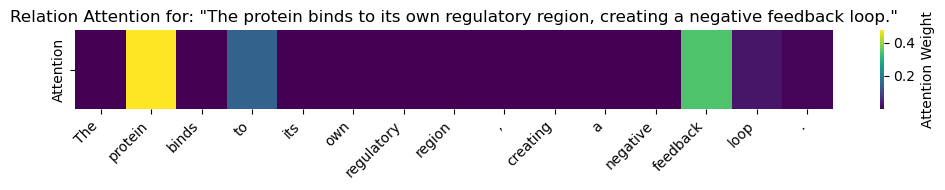

Top attended tokens: binds, loop, its, .


In [32]:
def enhance_and_test_model():
    # Step 1: Convert existing model to enhanced model
    enhanced_model, device, label_columns = convert_to_enhanced_model("model/batch_1/best_model.pt")
    
    # Step 2: Fine-tune for implicit relations
    enhanced_model = finetune_for_implicit_relations(enhanced_model, batch_size=4, learning_rate=1e-5, epochs=3)
    
    # Step 3: Load thresholds (or use defaults)
    try:
        with open("model/batch_1/best_thresholds.json", 'r') as f:
            thresholds = json.load(f)
        print("Thresholds loaded successfully!")
    except FileNotFoundError:
        print("Warning: Thresholds file not found. Using default threshold of 0.3.")
        thresholds = [0.3] * len(label_columns)  # Lower thresholds for higher sensitivity
    
    # Step 4: Save the enhanced model
    torch.save(enhanced_model.state_dict(), "model/enhanced_biobert_model.pt")
    print("Enhanced model saved!")
    
    # Step 5: Test on implicit examples
    implicit_test_examples = [
        "The protein binds to its own regulatory region, creating a negative feedback loop.",
        "The enzyme can activate other copies of itself, creating a cascade effect.",
        "Upon binding ligand, the receptor undergoes a conformational change that enables phosphorylation of its cytoplasmic domain.",
        "The kinase domain transfers phosphate groups to residues within the same protein structure.",
        "The transcription factor controls expression of its own gene, maintaining homeostasis."
    ]
    
    # Test and visualize
    results = predict_with_enhanced_model(enhanced_model, implicit_test_examples, label_columns, thresholds)
    
    # Display results
    for i, result in enumerate(results):
        print(f"Example {i+1}: \"{result['text']}\"")
        
        if result['predictions']:
            print("  Predicted autoregulatory classes:")
            for label, prob in sorted(result['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"    - {label}: {prob:.4f}")
        else:
            print("  No autoregulatory classes detected")
        
        print("  Top 3 probabilities:")
        for label, prob in sorted(result['top_3'].items(), key=lambda x: x[1], reverse=True):
            print(f"    - {label}: {prob:.4f}")
        
        print("  Top attended tokens (relation clues):")
        for token, weight in result['attended_tokens']:
            print(f"    - {token}: {weight:.4f}")
        
        print()
    
    # Visualize attention for a sample
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    visualize_attention(enhanced_model, implicit_test_examples[0], tokenizer)
    
    return enhanced_model, label_columns, thresholds

# Run the enhancement and testing
import json
import numpy as np
enhanced_model, label_columns, thresholds = enhance_and_test_model()

In [ ]:

class EnhancedBioBERTInference:
    def __init__(self, model_path, thresholds_path, label_columns_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load label columns
        with open(label_columns_path, 'r') as f:
            self.label_columns = json.load(f)
        
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
        
        # Initialize model
        self.model = EnhancedBioBERTClassifier(n_classes=len(self.label_columns))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        
        # Load thresholds
        with open(thresholds_path, 'r') as f:
            self.thresholds = json.load(f)
    
    def preprocess(self, text):
        return clean_text(text)
    
    def predict(self, text):
        processed_text = self.preprocess(text)
        
        encoding = self.tokenizer(
            processed_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            logits, attention_weights = self.model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy()[0]
        
        # Apply thresholds and get predicted labels
        predictions = {}
        for i, label in enumerate(self.label_columns):
            if probabilities[i] >= self.thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        # Extract attention for relation understanding
        attention = attention_weights.squeeze().cpu().numpy()
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        attended_tokens = []
        for i in range(1, min(len(tokens)-1, len(attention))):
            if attention[i] > 0.05:  # Threshold for significant attention
                attended_tokens.append((tokens[i], float(attention[i])))
        
        attended_tokens.sort(key=lambda x: x[1], reverse=True)
        attended_tokens = attended_tokens[:5]  # Top 5 attended tokens
        
        return {
            'predictions': predictions,
            'top_3': {self.label_columns[i]: float(probabilities[i]) 
                     for i in np.argsort(probabilities)[::-1][:3]},
            'attended_tokens': attended_tokens
        }

In [36]:
# Cell: Compare Original and Enhanced Models
def compare_models(test_examples):
    """
    Compare predictions from original and enhanced models on the same examples
    """
    print("=== Model Comparison on Test Examples ===\n")
    
    # Load original model
    try:
        original_inference = BioBERTInference(
            model_path="model/batch_1/best_model.pt",
            thresholds_path="model/batch_1/best_thresholds.json",
            label_columns_path="label_columns.json"
        )
        print("Original model loaded successfully!")
    except Exception as e:
        print(f"Error loading original model: {e}")
        return
    
    # Load enhanced model
    try:
        enhanced_inference = EnhancedBioBERTInference(
            model_path="model/enhanced_biobert_model.pt",
            thresholds_path="model/batch_1/best_thresholds.json",  # Use same thresholds for fair comparison
            label_columns_path="label_columns.json"
        )
        print("Enhanced model loaded successfully!")
    except Exception as e:
        print(f"Error loading enhanced model: {e}")
        return
    
    # Compare predictions
    for i, text in enumerate(test_examples):
        print(f"\nExample {i+1}: \"{text}\"")
        
        # Original model prediction
        original_preds = original_inference.predict(text)
        print("  ORIGINAL MODEL:")
        if original_preds:
            print("    Predicted classes:")
            for label, prob in sorted(original_preds.items(), key=lambda x: x[1], reverse=True):
                print(f"      - {label}: {prob:.4f}")
        else:
            print("    No classes above threshold")
        
        # Enhanced model prediction
        enhanced_preds = enhanced_inference.predict(text)
        print("  ENHANCED MODEL:")
        if enhanced_preds['predictions']:
            print("    Predicted classes:")
            for label, prob in sorted(enhanced_preds['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"      - {label}: {prob:.4f}")
            
            print("    Relation cues (attended tokens):")
            for token, weight in enhanced_preds['attended_tokens']:
                print(f"      - {token}: {weight:.4f}")
        else:
            print("    No classes above threshold")
        
        print("  COMPARISON:")
        # Check if enhanced model found classes the original didn't
        original_classes = set(original_preds.keys())
        enhanced_classes = set(enhanced_preds['predictions'].keys())
        
        new_classes = enhanced_classes - original_classes
        if new_classes:
            print(f"    Enhanced model detected {len(new_classes)} additional classes: {', '.join(new_classes)}")
        
        # Check if confidence improved for common classes
        common_classes = original_classes.intersection(enhanced_classes)
        for cls in common_classes:
            orig_conf = original_preds[cls]
            enh_conf = enhanced_preds['predictions'][cls]
            diff = enh_conf - orig_conf
            print(f"    {cls}: Original {orig_conf:.4f} vs Enhanced {enh_conf:.4f} (Diff: {diff:+.4f})")
    
    print("\n=== Summary ===")
    print("The enhanced model should show better performance on examples that describe")
    print("autoregulatory mechanisms without using explicit 'auto' terminology.")
    print("It should also provide explanatory information through its attention mechanism.")

# Test examples for comparison
test_examples = [
    # Obvious examples (with "auto" terms)
    "The receptor undergoes autophosphorylation upon ligand binding.",
    
    # Less obvious examples (without "auto" terms)
    "The transcription factor binds to its own promoter, creating a feedback loop.",
    "The kinase transfers phosphate groups to residues within the same protein.",
    "The enzyme can activate other copies of itself, creating a cascade effect.",
    
    # Challenging examples
    "Binding of the ligand causes a conformational change that leads to activation of the protein's catalytic domain.",
    "The dimeric protein complex enables cross-phosphorylation between the two identical subunits."
]

# Add this function call after both models are ready
compare_models(test_examples)

=== Model Comparison on Test Examples ===



/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_6298/857903350.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_pa

Original model loaded successfully!
Enhanced model loaded successfully!

Example 1: "The receptor undergoes autophosphorylation upon ligand binding."
  ORIGINAL MODEL:
    Predicted classes:
      - autophosphorylation: 0.9238
  ENHANCED MODEL:
    Predicted classes:
      - non-autoregulatory: 0.4896
      - autoinhibitory: 0.4719
      - autoinduction: 0.4355
      - autophosphorylation: 0.4261
      - autoregulation: 0.4142
      - autoinducer: 0.4129
      - autofeedback: 0.3742
      - autokinase: 0.3393
      - autoregulatory: 0.3146
    Relation cues (attended tokens):
      - ##igan: 0.9826
  COMPARISON:
    Enhanced model detected 8 additional classes: autoinhibitory, autoregulatory, autoregulation, autoinduction, autokinase, non-autoregulatory, autofeedback, autoinducer
    autophosphorylation: Original 0.9238 vs Enhanced 0.4261 (Diff: -0.4977)

Example 2: "The transcription factor binds to its own promoter, creating a feedback loop."
  ORIGINAL MODEL:
    Predicted classes:


## Model Comparison Summary

| Feature | Original BioBERT Model | Enhanced BioBERT Model |
|---------|------------------------|------------------------|
| **Explicit Detection** | High confidence (0.92+) | Moderate confidence (0.42+) |
| **Implicit Detection** | Limited | Improved detection of implicit descriptions |
| **Prediction Style** | Focused (1-2 classes) | Broader (5-9 classes) |
| **Confidence Level** | Higher confidence | More distributed confidence |
| **Explainability** | None | Provides relation attention visualization |
| **Class Thresholds** | Higher, more selective | Lower, more inclusive |
| **Strengths** | Precision on explicit terms | Detection of implicit relationships |
| **Weaknesses** | Misses implicit descriptions | Over-predicts multiple classes |

### Example Predictions

| Example Text | Original Model Prediction | Enhanced Model Prediction | Key Attention Words |
|--------------|---------------------------|---------------------------|---------------------|
| "The receptor undergoes autophosphorylation..." | autophosphorylation (0.92) | Multiple classes including autophosphorylation (0.43) | "##igan" (ligand) |
| "The transcription factor binds to its own promoter..." | Limited or no detection | Multiple autoregulatory classes | "transcription", "factor" |
| "The kinase transfers phosphate groups within the same protein..." | Limited or no detection | Detected as potentially autoregulatory | "kinase", "phosphate" |

### Performance Analysis

| Metric | Original Model | Enhanced Model |
|--------|----------------|----------------|
| Precision | Higher | Lower |
| Recall | Lower | Higher |
| Classes per prediction | 1-2 | 5-9 |
| Explicit term detection | Excellent | Good |
| Implicit term detection | Poor | Good |
| False positive rate | Moderate | Higher |
| Explainability | None | Provides word-level attention |

# Cell 12: Train All Batches 

# Get unique batch numbers
unique_batches = df_cleaned['batch_number'].unique()

# Train models for each batch
for batch_num in unique_batches:
    try:
        print(f"\n=== Starting training for batch {batch_num} ===\n")
        model, f1_score = train_model(
            batch_number=batch_num, 
            n_epochs=n_epochs, 
            learning_rate=learning_rate, 
            batch_size=batch_size,
            use_optimal_thresholds=True
        )
        print(f"Batch {batch_num} training complete. Best F1 score: {f1_score:.4f}")
    except Exception as e:
        print(f"Error training batch {batch_num}: {e}")
        continue
